# Analysis


In [618]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

In [821]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug = 'country_brazil'
""", conn)

In [696]:
#df.head()

### mobility

In [822]:
df_union=pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv") 
df_mean = (df_union
 >> filter(_.date >= '2020-03-23', _.date <= '2020-03-29')
 >> group_by('region_slug', 'measure')
 >> summarize(mean_val = _.value.mean())
 >> ungroup()
)
df_mean.head()
df_scale = (df_union.merge(df_mean.reset_index(), on=['region_slug', 'measure'], how='left')
 >> mutate(value_rescaled = -100*_.value/_.mean_val)
 >> select('region_slug', 'country_name', 'date', 'measure', 'value_rescaled')
 >> spread('measure', 'value_rescaled')
)
df_scale['date'] = df_scale['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
#df_scale.dtypes

## Day of week data

In [698]:
df_dow = (df
 >> select( 'region_slug', 'date',  'dow', 'observed', 'tcp') 
 >> mutate( aux_var = (_.dow == 1))
 >> arrange(_.region_slug, _.date)
 >> group_by('region_slug')
 >> mutate( week = _.aux_var.cumsum())
 >> ungroup()
 >> group_by('region_slug', 'week')
 >> mutate( min_date = _.date.min())
 >> ungroup()
 >> select( 'region_slug', 'dow', 'date', 'min_date', 'week', 'observed', 'tcp')
 >> arrange('region_slug', 'dow', 'date')
 >> group_by('region_slug', 'dow')
 >> mutate(tcp_ma = _.tcp.rolling(3).mean(),
           obs_ma = _.observed.rolling(3).mean())
 >> ungroup()          
).dropna()
df_dow['log_observed'] = np.log(df_dow['observed'])
#df_dow.head(2)

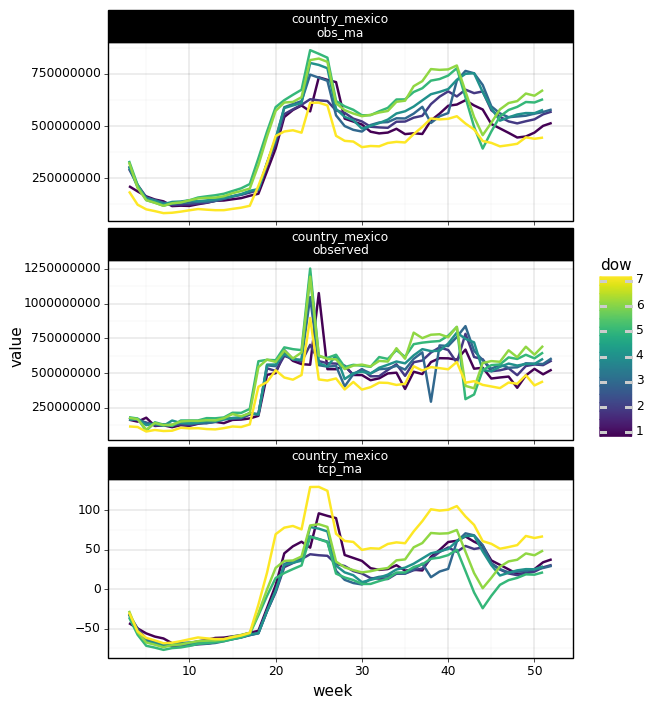

<ggplot: (8757124319965)>

In [699]:
(p9.ggplot(data=(df_dow
                 >> select('region_slug', 'dow', 'date', 'week', 
                           'tcp_ma', 'obs_ma', 'observed')
                 >> gather('measure', 'value', _["tcp_ma", "obs_ma", "observed"])),
           mapping=p9.aes(x='week', y='value', 
                          color = 'dow', group = 'dow')) 
    + p9.geom_line(size=1) 
    + p9.facet_wrap(['region_slug', 'measure'], ncol = 1, scales='free') 
    + p9.theme(figure_size = (6, 8),
                axis_text_x=p9.element_text(angle=0)) )

In [700]:
tab = (df_dow
 >> group_by('region_slug', 'dow')
 >> summarize(n_obs = _.min_date.count())
 >> ungroup()
)
spread(tab, 'dow', 'n_obs')

,region_slug,1,2,3,4,5,6,7
0,country_mexico,50,50,50,49,49,49,49


In [746]:
# series to validate
y_df = df_dow \
    .siu_arrange('date') \
    .siu_rename(obs = 'observed') \
    .siu_select('date', 'obs') \
    .set_index('date')
s = validate_series(y_df)

## Outliers detection

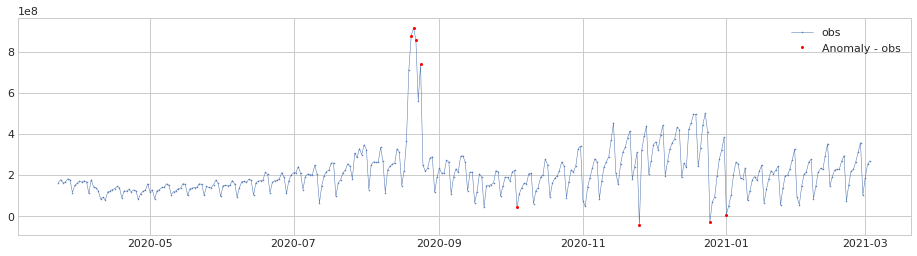

In [820]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
steps = [
    ("quantile_ad", QuantileAD(high=0.99, low=0.01))
]
pipeline = Pipeline(steps)
anomalies_pipe = pipeline.fit_detect(s_c)
plot(s_c, anomaly=anomalies_pipe, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

In [749]:
(anomalies_pipe \
    .rename(columns={'obs':'outlier'}) \
    .reset_index() \
    .merge(df_dow, how='inner')
 >> group_by('dow', 'region_slug')
 >> summarize(n_obs = _.date.count(),
              n_out = _.outlier.sum())
 >> ungroup()
 >> mutate(pct_out = 100*_.n_out/_.n_obs)
)

,dow,region_slug,n_obs,n_out,pct_out
0,1,country_mexico,50,1,2.000000
1,2,country_mexico,50,0,0.000000
2,3,country_mexico,50,0,0.000000
3,4,country_mexico,49,1,2.040816
4,5,country_mexico,49,2,4.081633
5,6,country_mexico,49,1,2.040816
6,7,country_mexico,49,3,6.122449


## Smoothing for day of the week

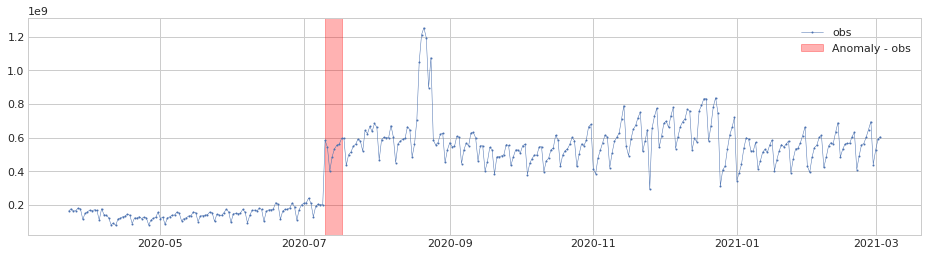

In [793]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

In [794]:
anomalies.siu_filter(_.obs ==1)

,obs
date,
2020-07-10,1.0
2020-07-11,1.0
2020-07-12,1.0
2020-07-13,1.0
2020-07-14,1.0
2020-07-15,1.0
2020-07-16,1.0


In [809]:
((df_dow[(df_dow['date'] > '2020-06-25') & (df_dow['date'] <= '2020-07-09')].observed.mean())-( df_dow[(df_dow['date'] > '2020-07-09') & (df_dow['date'] <= '2020-07-23')].observed.mean()))
df_dow['observed_centered'] = df_dow['observed']
df_dow['observed_centered'][(df_dow['date'] > '2020-07-09')] = df_dow['observed'][(df_dow['date'] > '2020-07-09')] -337479847.71428573
(p9.ggplot(data=df_dow,
           mapping=p9.aes(x='date', y='observed_centered')) 
    + p9.geom_line(size = 2) 
)

-337479847.71428573

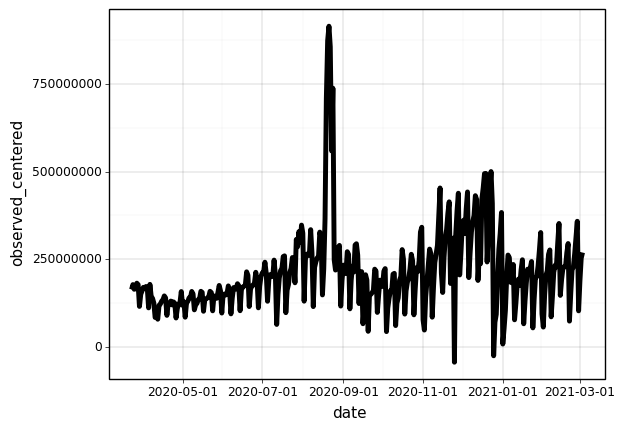

<ggplot: (8757122776069)>

In [813]:
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

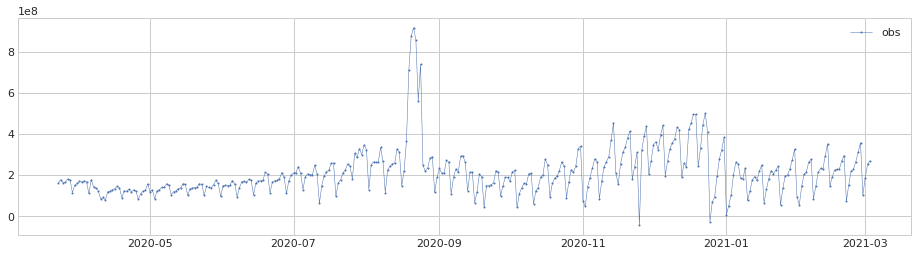

In [819]:
y_df = df_dow \
    .siu_arrange('date') \
    .siu_rename(obs = 'observed_centered') \
    .siu_select('date', 'obs') \
    .set_index('date')
s_c = validate_series(y_df)
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s_c)
plot(s_c, anomaly=anomalies, anomaly_color='red');

## Comparison

In [743]:
df_s['baseline']=df_dow \
    .siu_filter(_.date >= '2020-03-23', _.date <= '2020-03-29') \
    .observed.mean()
df_s['tcp_adj'] = 100*(df_s['obs_tr']-df_s['baseline'])/df_s['baseline']
#df_s.head()

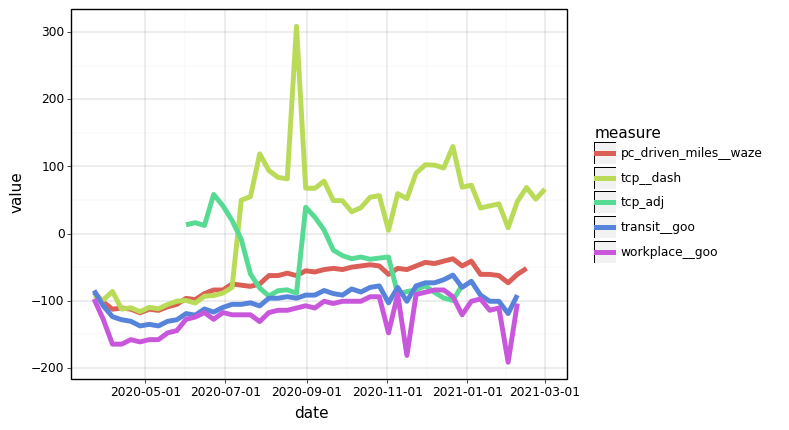

<ggplot: (8757124261753)>

In [744]:
df=df_dow \
    .merge(df_scale, on=['date', 'region_slug'], how='left') \
    .merge(df_s, on='date', how='inner') \
    .siu_select('region_slug', 'date', 
                'tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo') \
    .siu_gather('measure', 'value', _['tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo'])
(p9.ggplot(data=df,
           mapping=p9.aes(x='date', y='value', color = 'measure')) 
    + p9.geom_line(size = 2) 
)